# HDF5 vs Feather file format

## Objective
- Comparison between the storing time of both formats.
- Comparison between the reading time of both formats.
- Comparison between the file sizes of both formats.

### Import files
Import all the necessary files.

In [57]:
'''Importing necessary files.'''
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pyarrow
import requests
from io import StringIO

### Getting ticker list and Intraday EOD historical data
Getting ticker list for the 'BSE' exchange and getting historical data from these tickers of 30 companies and store these dataframe in a dictionary.

In [5]:
api_key = os.environ['EOD_API_KEY']

'''Getting Ticker list from the URL.'''
class NoSuchExchange(Exception):
    def __init__(self, message: str= "No such exhange supported."):
        self.message = message
        super().__init__(message)

def get_ticker_list(exchange, api_token, session=None):
    '''
    This function takes exchange symbol like "BSE\NSE\US" and api_token and returns a dataframe of all the companies listed in that exchange.
    '''
    if exchange not in ['BSE', 'NSE']:
        raise NoSuchExchange()
    
    if session is None:
        session=requests.Session()
        url = 'https://eodhistoricaldata.com/api/exchange-symbol-list/%s' % exchange
        params = {'api_token': api_token}
        r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df

'''Function for extracting Intraday historical data from EODhistoricaldata. '''
def get_eod_data(symbol, api_token="xxxx", session=None):
    '''
    This function takes the arguments company symbol and api_key and returns a dataframe of the historical data of the company.
    It creates a session with the EOD server using api key.
    '''
    if session is None:
        session = requests.Session()
        url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
        params = {"api_token": api_token}
        r = session.get(url, params=params)

    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df

'''
Calling function get_ticker_list to get the ticker list.
'''
ticker_list = get_ticker_list('BSE', api_key).sample(30).reset_index()
ticker = list(ticker_list['Code'])           # extracts the list of company codes from the dataframe, ticker_list

'''
Calling function get_eod_data to get the intraday historical data from the EOD server. Pass the ticker name with the exchange code e.g. {ticker_id}.{exchange_code}
'''
df_dict = dict()
for tick in ticker:
    df_dict[tick] = get_eod_data(tick+'.BSE', api_key)     #extracts the historical data in the dictionary 

### Evaluate the stroing time, reading time and file sizes for both formats.
Let's get pandas dataframes from the df_dict, with numbers of rows N = 2**n. For each number of rows, we measure the time used by .to_hdf() and .to_feather(), evaluate the size of the resulting file, and measure the time used by .read_hdf() and .read_feather()

In [52]:
rows = []
stats = dict()
directory_hdf_file = 'C:\\Users\\Lenovo\\Desktop\\technoculture\\hdf_files\\'                          # Directory location where you want to store hdf files.
directory_feather_file = 'C:\\Users\\Lenovo\\Desktop\\technoculture\\feather_files\\'                  # Directory location where you want to store feather files.
'''
In the stats dictionary we define 3 keys:
    1. storing_times - store the time when the file format is written in the system.
    2. reading_time - store the time when program reads the file format from the system.
    3. size - store the size of the files in Mb.
These three keys are futher divided in two dictionaries in which one store the data of "HDF Files" and other will store the data of "feather Files".
'''
stats['storing_times'] = dict()
stats['reading_times'] = dict()
stats['sizes'] = dict()
stats['storing_times']['HDF'] = dict()
stats['reading_times']['HDF'] = dict()
stats['sizes']['HDF'] = dict()
stats['storing_times']['Feather'] = dict()
stats['reading_times']['Feather'] = dict()
stats['sizes']['Feather'] = dict()
i=8
for n, value in df_dict.items():
    i+=1
    '''
    numbers of rows N=2**n , for the log calculation
    '''
    n_rows = 2**i
    rows.append(n_rows)
    '''
    This will convert the dataframes in to the hdf and feather file formats using to_hdf() and to_feather() and store their processing time in the stats dictionary.
    '''
    hdf_storing_time = %timeit -q -n1 -o value.to_hdf(directory_hdf_file+'hdf_'+ str(n_rows) + '.hdf',key=n)
    stats['storing_times']['HDF'][n_rows] = hdf_storing_time.best
    feather_storing_time = %timeit -q -n1 -o value.reset_index().to_feather(directory_feather_file+'feather_' + str(n_rows) + '.fth')
    stats['storing_times']['Feather'][n_rows] = feather_storing_time.best
    '''
    This will get the size of the hdf and feather file formats, convert it in Mb, and store their sizes in the stats dictionary.
    '''
    hdf_size = os.stat(directory_hdf_file + 'hdf_'+ str(n_rows) + '.hdf').st_size/1024/1024
    stats['sizes']['HDF'][n_rows] = hdf_size
    feather_size = os.stat(directory_feather_file+'feather_' + str(n_rows) + '.fth').st_size/1024/1024
    stats['sizes']['Feather'][n_rows] = feather_size
    '''
    Here, will read the hdf and feather file formats using read_hdf() and read_feather() and store their processing time in the stats dictionary.
    '''
    hdf_reading_time = %timeit -q -n1 -o large_read = pd.read_hdf(directory_hdf_file+'hdf_'+ str(n_rows) + '.hdf',key=n)
    stats['reading_times']['HDF'][n_rows] = hdf_reading_time.best
    feather_reading_time = %timeit -q -n1 -o large_read = pd.read_feather(directory_feather_file+'feather_' + str(n_rows) + '.fth')
    stats['reading_times']['Feather'][n_rows] = feather_reading_time.best

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '505714'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '500124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '505712'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural

In [53]:
'''
Convert dictionary into the dataframe, and Merge them to get the final result.
'''
dic = {'storing_times' : pd.DataFrame(stats['storing_times']), 'sizes' : pd.DataFrame(stats['sizes']), 'reading_times' : pd.DataFrame(stats['reading_times'])}
res = pd.concat(dic.values(),axis=1,keys=dic.keys())

### Comparison between the values of HDF and Feather files
Let's evaluate the storing time, reading time, and file size by calculating the percentages of difference in stroing time, reading time and file size. And find out which is more flexible. 

In [67]:
difference_in_storing_time = sum(res['storing_times']['HDF']) - sum(res['storing_times']['Feather']) 
difference_in_reading_time = sum(res['reading_times']['HDF']) - sum(res['reading_times']['Feather'])
difference_in_file_size = sum(res['sizes']['HDF']) - sum(res['sizes']['HDF'])
percentage_difference_in_storing_time = difference_in_storing_time *100
percentage_difference_in_reading_time = difference_in_reading_time *100
percentage_difference_in_file_size = difference_in_file_size *100
print(r'HDF files take {:.2f}% more storing time than Feather files.'.format(percentage_difference_in_storing_time))
print(r'HDF files take {:.2f}% more reading time than Feather files.'.format(percentage_difference_in_reading_time))
print(r'HDF files take {:.2f}% more storage than Feather files.'.format(percentage_difference_in_file_size))

HDF files take 50.46% more storing time than Feather files.
HDF files take 37.53% more reading time than Feather files.
HDF files take 0.00% more storage than Feather files.


### Plotting the graph
Let's plot the graph to visualize the comparison between the writing time, file size and reading time of HDF and Feather files.

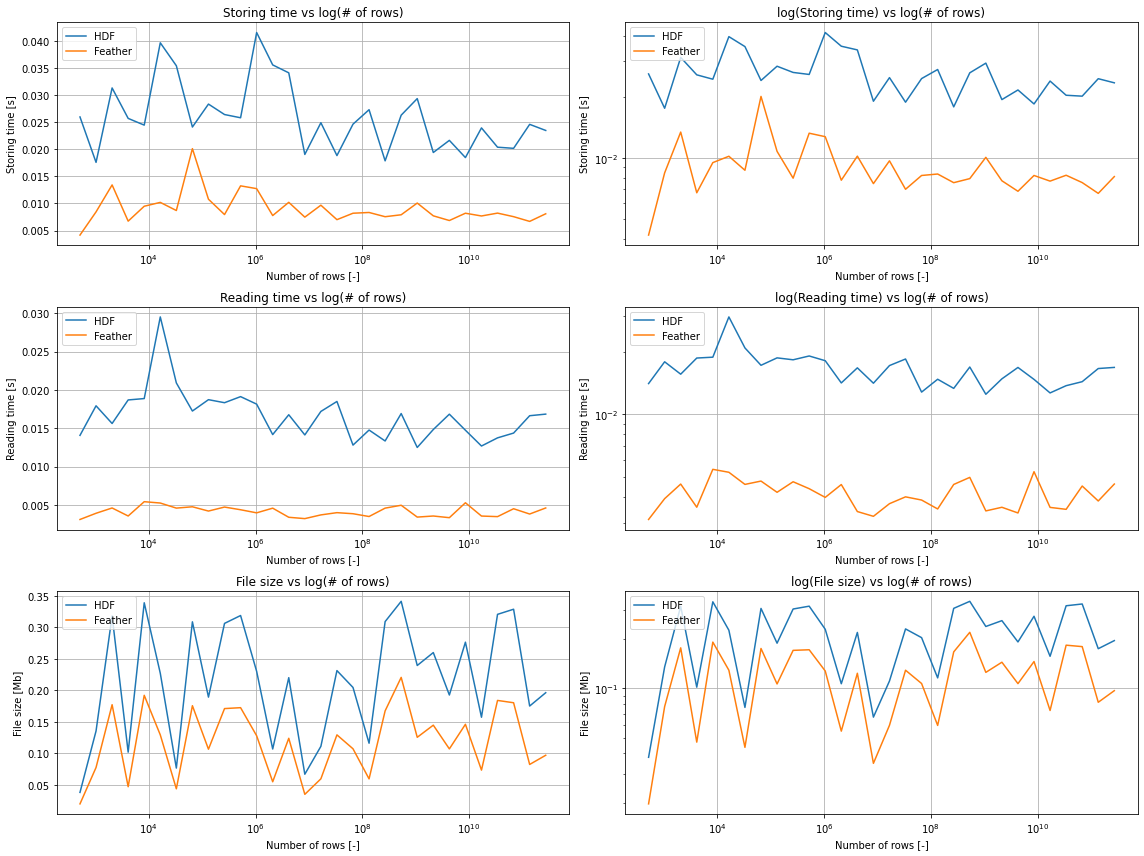

In [55]:
fig, ax = plt.subplots(3,2, figsize=(16,12))

# Storing times
res['storing_times'].plot(ax=ax[0][0])
ax[0][0].set_xticks(rows)
ax[0][0].set_xscale('log')
ax[0][0].set_xlabel('Number of rows')
ax[0][0].set_ylabel('Storing time [s]')
ax[0][0].set_title('Storing time vs log(No. of rows)')
ax[0][0].grid()
ax[0][0].legend(loc=2)

res['storing_times'].plot(ax=ax[0][1])
ax[0][1].set_xticks(rows)
ax[0][1].set_xscale("log")
ax[0][1].set_yscale("log")
ax[0][1].set_xlabel('Number of rows')
ax[0][1].set_ylabel('Storing time [s]')
ax[0][1].grid()
ax[0][1].set_title('log(Storing time) vs log(No. of rows)')
ax[0][1].legend(loc=2)

# Reading times
res['reading_times'].plot(ax=ax[1][0])
ax[1][0].set_xticks(rows)
ax[1][0].set_xscale("log")
ax[1][0].set_xlabel('Number of rows ')
ax[1][0].set_ylabel('Reading time [s]')
ax[1][0].set_title('Reading time vs log(No. of rows)')
ax[1][0].grid()
ax[1][0].legend(loc=2)

res['reading_times'].plot(ax=ax[1][1])
ax[1][1].set_xticks(rows)
ax[1][1].set_xscale("log")
ax[1][1].set_yscale("log")
ax[1][1].set_xlabel('Number of rows')
ax[1][1].set_ylabel('Reading time [s]')
ax[1][1].grid()
ax[1][1].set_title('log(Reading time) vs log(No. of rows)')
ax[1][1].legend(loc=2)

# Sizes
res['sizes'].plot(ax=ax[2][0])
ax[2][0].set_xticks(rows)
ax[2][0].set_xscale("log")
ax[2][0].set_xlabel('Number of rows')
ax[2][0].set_ylabel('File size [Mb]')
ax[2][0].set_title('File size vs log(No. of rows)')
ax[2][0].grid()
ax[2][0].legend(loc=2)

res['sizes'].plot(ax=ax[2][1])
ax[2][1].set_xticks(rows)
ax[2][1].set_xscale("log")
ax[2][1].set_yscale("log")
ax[2][1].set_xlabel('Number of rows')
ax[2][1].set_ylabel('File size [Mb]')
ax[2][1].legend(loc=2)
ax[2][1].grid()
ax[2][1].set_title('log(File size) vs log(No. of rows)')

fig.tight_layout()

Now let's plot the "HDF/Feather" speedup and size ratios:

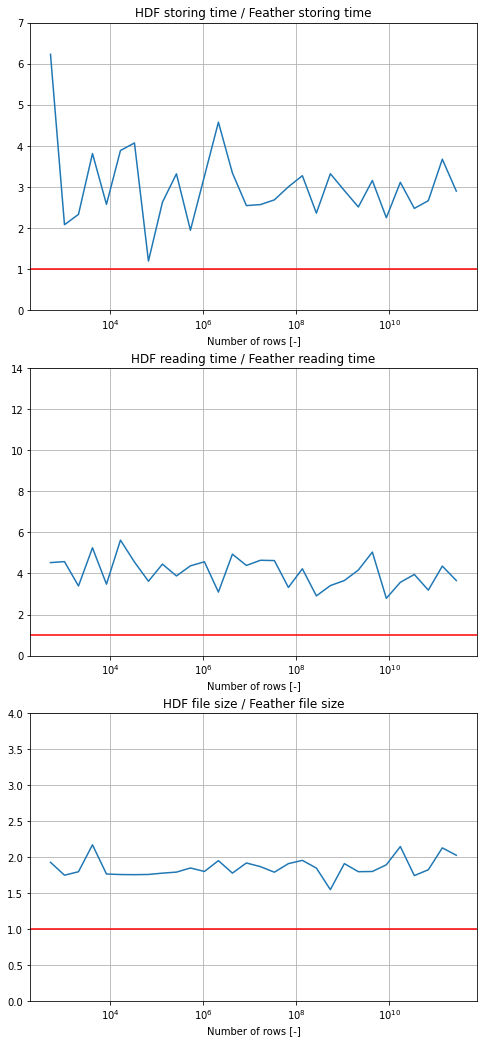

In [56]:
fig, ax = plt.subplots(3,1, figsize=(8,18))
(res['storing_times']['HDF']/res['storing_times']['Feather']).plot(ax=ax[0])
ax[0].set_xscale("log")
ax[0].set_ylim([0,7])
ax[0].grid()
ax[0].set_title('HDF storing time / Feather storing time')
ax[0].set_xlabel('Number of rows [-]')
ax[0].axhline(1.0, color='r')
(res['reading_times']['HDF']/res['reading_times']['Feather']).plot(ax=ax[1])
ax[1].set_xscale("log")
ax[1].set_ylim([0,14])
ax[1].grid()
ax[1].set_title('HDF reading time / Feather reading time')
ax[1].axhline(1.0, color='r')
ax[1].set_xlabel('Number of rows [-]')
(res['sizes']['HDF']/res['sizes']['Feather']).plot(ax=ax[2])
ax[2].set_xscale("log")
ax[2].set_ylim([0,4])
ax[2].grid()
ax[2].set_title('HDF file size / Feather file size')
ax[2].axhline(1.0, color='r')
ax[2].set_xlabel('Number of rows [-]');

# Conclusion

#### HDF vs Feather  

| Storing Time | Reading Time | File Size |
|:---:|:---:|:---:|
|HDF files take 50.46% more storing time than Feather files. | HDF files take 37.53% more reading time than Feather files. |Almost same storage consumption by HDF and Feather files. |

##### Feather files are more faster than HDF files in terms of processing time.